# Group 4 EDA

-------------------------
Amber Curran (akc6be)

Manpreet Dhindsa (mkd8bb)

Quinton Mays (rub9ez)

---------------------------

To begin, I set up the spark session.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("comm2") \
        .getOrCreate()

Next, I import Pandas to read in the data dictionary file that is provided alongside the data.

In [2]:
import pandas as pd

In [3]:
schemadf = pd.read_csv('/project/ds5559/fa21-group04/data/WiDS_Datathon_2020_Dictionary.csv')

Next, I create a dictionary that maps the data types from the data dictionary to their corresponding Spark datatypes.

In [4]:
from pyspark.sql.types import *
data_types = {
    'integer': IntegerType(),
    'binary': IntegerType(),
    'numeric': FloatType(),
    'string': StringType()
}

I then use list comprehension to build the Spark schema for the dataframe using the information stored in the Pandas dataframe. There is probably a Spark way to do this, but I didn't want to figure it out.

In [5]:
schema = StructType(
    [
        StructField(row['Variable Name'] , 
                    data_types[row['Data Type']], 
                    True) for index, row in schemadf.iterrows()
    ]
)

I then use the created schema to create the Spark dataframe and then check to make sure that the schema is correct. aaa

In [6]:
df = spark.read.format('csv') \
    .schema(schema) \
    .option('header', True) \
    .load('/project/ds5559/fa21-group04/data/training_v2.csv')

In [7]:
df.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_id: integer (nullable = true)
 |-- hospital_id: integer (nullable = true)
 |-- hospital_death: integer (nullable = true)
 |-- age: float (nullable = true)
 |-- bmi: string (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: float (nullable = true)
 |-- hospital_admit_source: string (nullable = true)
 |-- icu_admit_source: string (nullable = true)
 |-- icu_admit_type: string (nullable = true)
 |-- icu_id: integer (nullable = true)
 |-- icu_stay_type: string (nullable = true)
 |-- icu_type: string (nullable = true)
 |-- pre_icu_los_days: float (nullable = true)
 |-- readmission_status: integer (nullable = true)
 |-- weight: float (nullable = true)
 |-- albumin_apache: float (nullable = true)
 |-- apache_2_diagnosis: string (nullable = true)
 |-- apache_3j_diagnosis: string (nullable = true)
 |-- apache_post_operative: in

In [8]:
df.select([df.columns[i] for i in range(10,30)]).show(5)

+---------------------+--------------------+--------------+------+-------------+-----------+----------------+------------------+------+--------------+------------------+-------------------+---------------------+----------+----------------+----------+-----------------+-----------+---------------+----------------+
|hospital_admit_source|    icu_admit_source|icu_admit_type|icu_id|icu_stay_type|   icu_type|pre_icu_los_days|readmission_status|weight|albumin_apache|apache_2_diagnosis|apache_3j_diagnosis|apache_post_operative|arf_apache|bilirubin_apache|bun_apache|creatinine_apache|fio2_apache|gcs_eyes_apache|gcs_motor_apache|
+---------------------+--------------------+--------------+------+-------------+-----------+----------------+------------------+------+--------------+------------------+-------------------+---------------------+----------+----------------+----------+-----------------+-----------+---------------+----------------+
|                Floor|               Floor|            92

Number of records:

In [9]:
df.count()

91713

Number of columns:

In [10]:
len(df.columns)

188

Statistical summary of response variable:

In [11]:
df.describe(['hospital_death']).show()

+-------+-------------------+
|summary|     hospital_death|
+-------+-------------------+
|  count|              91713|
|   mean|0.08630183289173836|
| stddev|0.28081076605005423|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [12]:
from pyspark.sql.functions import *

In [13]:
amount_missing_df = df.select([(count(when(isnan(c) | col(c).isNull(), c))/count(lit(1))).alias(c) for c in df.columns])

In [14]:
amount_missing_df_pd = amount_missing_df.toPandas().transpose()

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

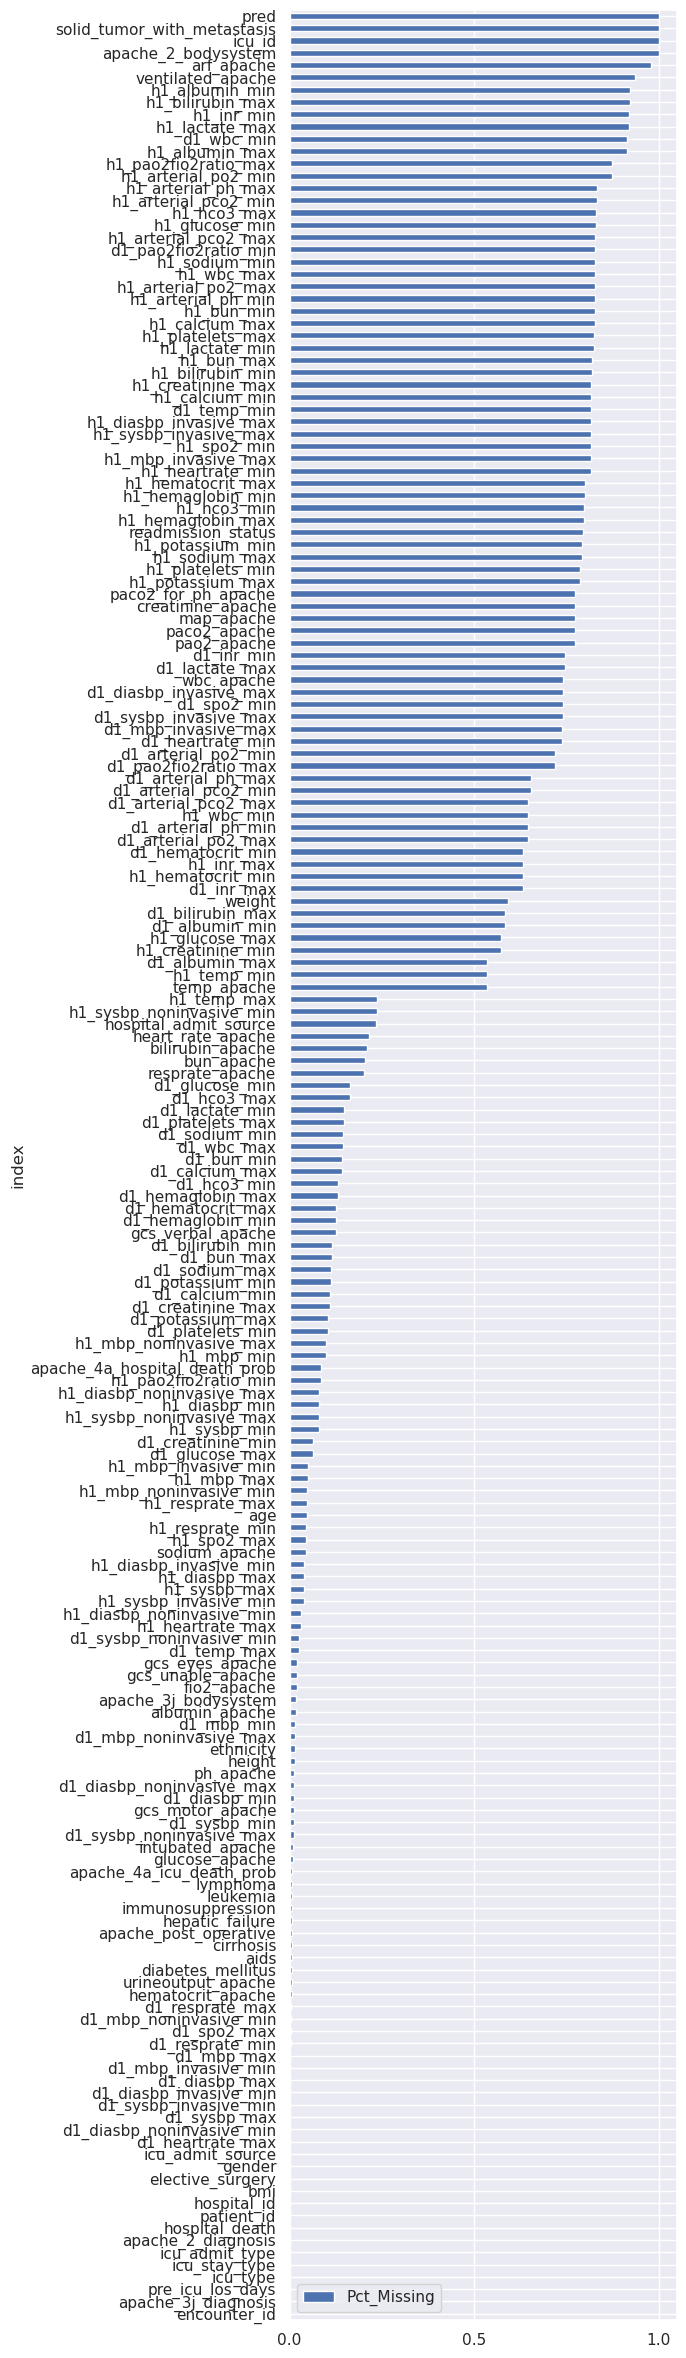

In [16]:
amount_missing_df_pd.sort_values(by=0,ascending=True).reset_index().rename(columns={0: "Pct_Missing"}).plot.barh(x='index', y='Pct_Missing', figsize=(5,30))
plt.xticks([0, 0.5, 1])
plt.show()

Drop the columns that have more than 50% missing data:

In [17]:
#df = spark.read.csv('/project/ds5559/fa21-group04/data/training_v2.csv')
import pyspark.sql.functions as F

df = spark.read.option("header",True).csv('/project/ds5559/fa21-group04/data/training_v2.csv')

def drop_null_columns(df):
    null_counts = df.select([((F.count(F.when(F.isnan(c) | F.col(c).isNull() | col(c).contains('NA'), c)))*100/df.count()).alias(c)  for c in df.columns]).collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v > 50]
    df = df.drop(*to_drop)
    return df
newdf = drop_null_columns(df)
len(newdf.columns)

#https://www.datasciencemadesimple.com/drop-column-in-pyspark-drop-single-multiple-columns/

112

In [18]:
newdf.show(1)

+------------+----------+-----------+--------------+---+-----+----------------+---------+------+------+---------------------+----------------+------+-------------+--------+----------------+------------------+------+------------------+-------------------+---------------------+----------+----------+-----------------+---------------+----------------+-----------------+-----------------+--------------+-----------------+-----------------+----------------+----------+---------------+-------------+-----------+-----------------+----------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-----------+-----------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+--

Two additional columns `encounter_id` and `patient_id` are dropped as they do not provide any relevant information to the model.

In [19]:
cleaned_df = newdf.drop('encounter_id').drop('patient_id')

In [20]:
len(cleaned_df.columns)

110

In [21]:
cleaned_df = cleaned_df.dropDuplicates() 

In [22]:
cleaned_df.count()

91713

Fortunately, there are no duplicate rows in the data. 

Next, we can start to explore the data.

## Exploration of number of deaths by hospital

To begin the exploration, a new dataframe is created using a groupBy to aggregate on hospital_id and provide the sum (death is represented as a 1, survived is 0) and the count of the total number of cases per hospital.

In [23]:
hospital_deaths = cleaned_df.groupBy('hospital_id').agg(sum('hospital_death').alias('total_deaths'), count('hospital_death').alias('total_patients'))

In [24]:
hospital_deaths = hospital_deaths.withColumn('death_pct', hospital_deaths.total_deaths / hospital_deaths.total_patients)

In [25]:
hospital_death_counts = hospital_deaths.toPandas()

In [26]:
hospital_death_counts.sort_values(by='death_pct', ascending=True).head()

,hospital_id,total_deaths,total_patients,death_pct
42,43,0.0,173,0.0
27,85,0.0,133,0.0
129,66,0.0,22,0.0
84,38,0.0,10,0.0
134,72,0.0,15,0.0


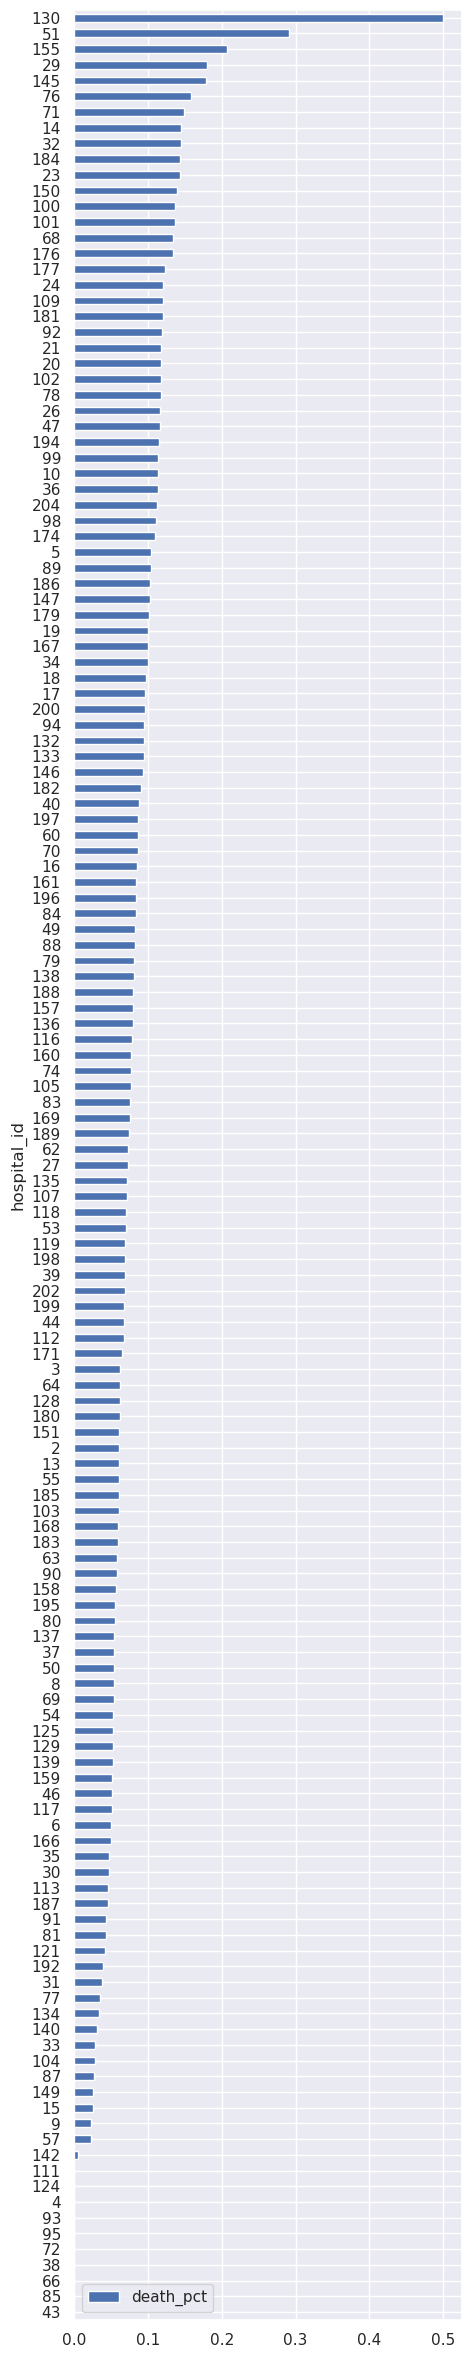

In [27]:
hospital_death_counts.sort_values(by='death_pct', ascending=True).plot.barh(x='hospital_id', y='death_pct', figsize=(5,30))
plt.show()

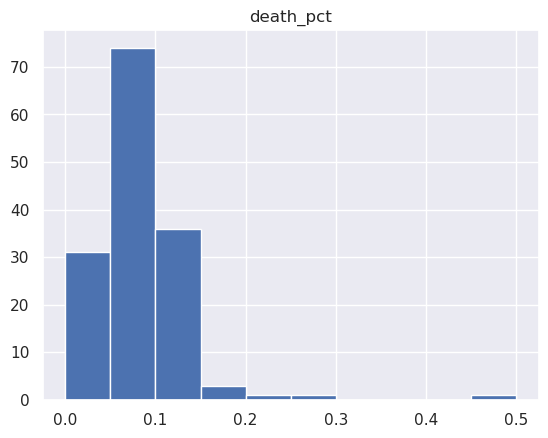

In [28]:
hospital_death_counts.hist(column='death_pct')
plt.show()

It is clear that the distribution of hopsital death percentages is very left skewed, which is a great thing for patients. The presence of hospitals that have no deaths could also affect the final model, as going to that hospital could be seen as a guarantee of survival!

Plot showing distribution of response variable:

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


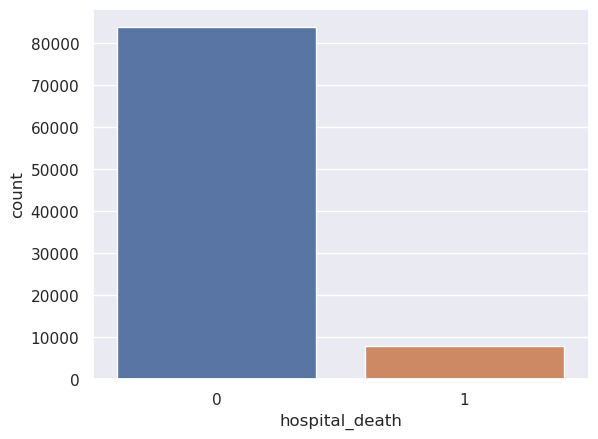

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Response Variable Distribution
pandasdf = cleaned_df.toPandas()
x = pandasdf['hospital_death']
sns.countplot(x)
plt.show()

Plots showing categorical variables:

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn

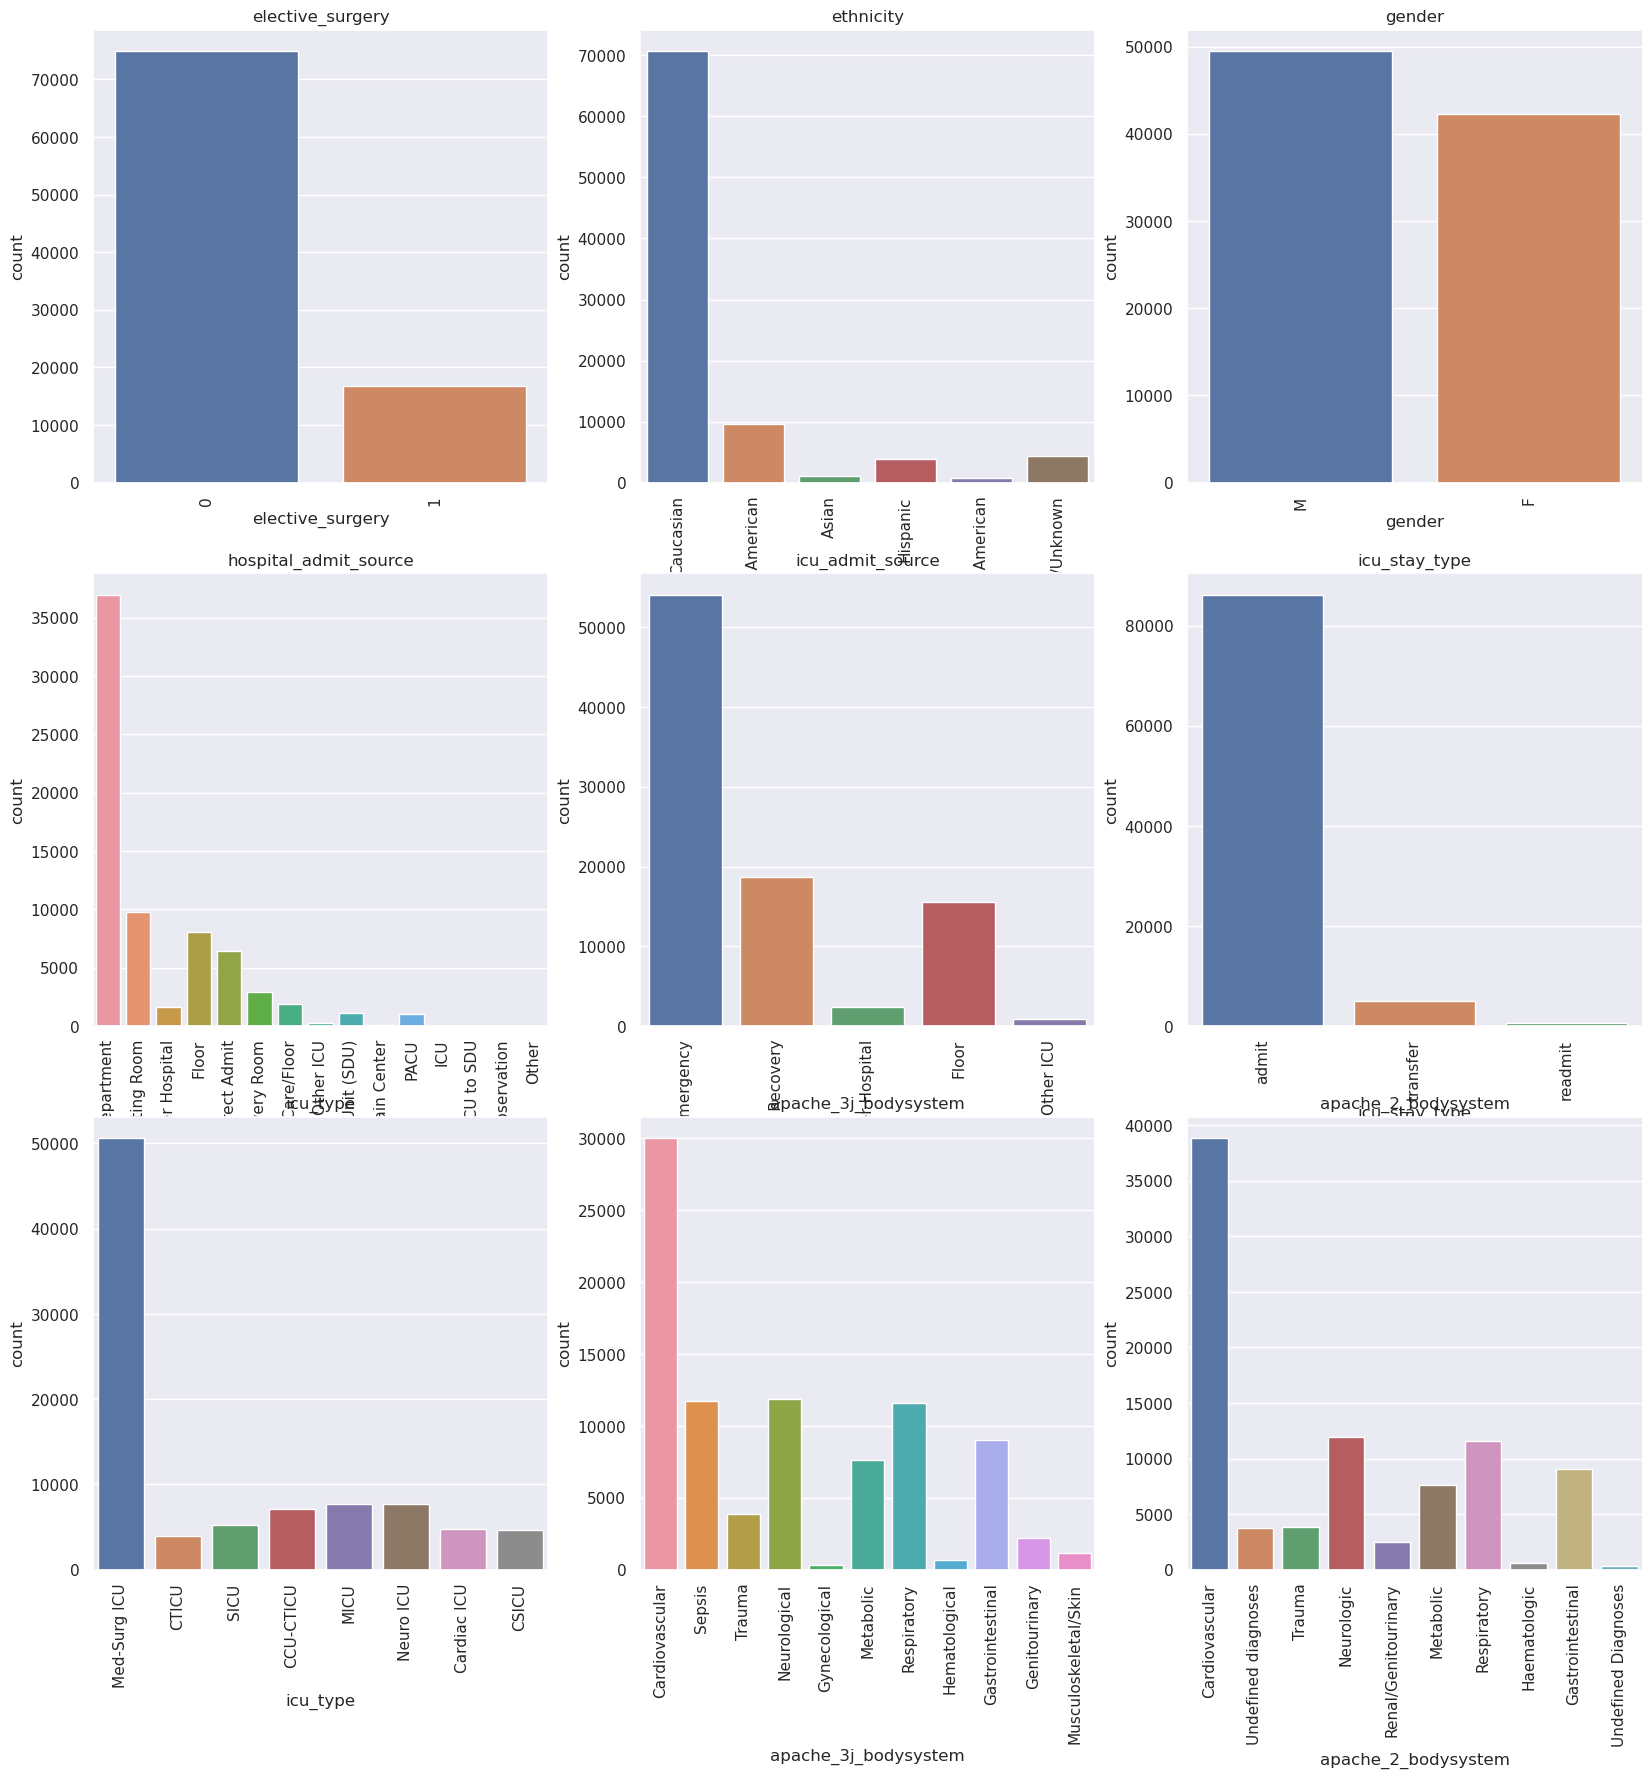

In [30]:
# Categorical Variables
categorical = ['elective_surgery', 'ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem']
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for variable, subplot in zip(categorical, ax.flatten()):
    x = pandasdf[variable]
    sns.countplot(x, ax=subplot).set(title=variable)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
plt.show()


Plots showing numerical variables:

In [31]:
# Numerical Variables
#numerical = ['age', 'bmi', 'elective_surgery', 'weight', 'heart_rate_apache', 'intubated_apache', 'ventilated_apache', 'immunosuppression', 'leukemia']
#fig, ax = plt.subplots(3, 3, figsize=(20, 20))
#for variable, ax in zip(numerical, ax.flatten()):
#    ax.hist(pandasdf[pandasdf["hospital_death"]==1][variable], bins=10, alpha=0.5, color="blue", label="died")
#    ax.hist(pandasdf[pandasdf["hospital_death"]==0][variable], bins=10, alpha=0.5, color="green", label="did not die")
#    ax.set_ylabel("Count of patients")
#    ax.set_xlabel(variable)
#    ax.legend()
#    for label in subplot.get_xticklabels():
#        label.set_rotation(90)
#plt.show()


Plan for predictor variables:

-can drop the “identifier” variables

-all demographic ones will be kept

-max and min variables will be condensed to a range then make categorical and group as low, medium, high risk

-use apache hospital death prob and apache icu death prob rather than the all of the apache covariates

-keep all apache comorbidity and apache grouping columns

-drop GOSSIS example prediction since we have the hospital and icu death probs

Statistical summary of a few predictor variables since we know that these will most likely be important for the model:

In [32]:
df.describe(['elective_surgery']).show()

+-------+-------------------+
|summary|   elective_surgery|
+-------+-------------------+
|  count|              91713|
|   mean|0.18373622060122338|
| stddev|0.38727103835274657|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [33]:
df.describe(['readmission_status']).show()

+-------+------------------+
|summary|readmission_status|
+-------+------------------+
|  count|             91713|
|   mean|               0.0|
| stddev|               0.0|
|    min|                 0|
|    max|                 0|
+-------+------------------+



In [34]:
df.describe(['age']).show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|             91713|
|   mean|62.309515917014345|
| stddev|16.775118786639798|
|    min|                16|
|    max|                NA|
+-------+------------------+



In [35]:
df.describe(['weight']).show()

+-------+------------------+
|summary|            weight|
+-------+------------------+
|  count|             91713|
|   mean| 84.02833953232108|
| stddev|25.011496809437027|
|    min|               100|
|    max|                NA|
+-------+------------------+



In [36]:
df.describe(['apache_4a_hospital_death_prob']).show()

+-------+-----------------------------+
|summary|apache_4a_hospital_death_prob|
+-------+-----------------------------+
|  count|                        91713|
|   mean|          0.08678688250607246|
| stddev|          0.24756853504248966|
|    min|                           -1|
|    max|                           NA|
+-------+-----------------------------+



In [37]:
df.describe(['apache_4a_icu_death_prob']).show()

+-------+------------------------+
|summary|apache_4a_icu_death_prob|
+-------+------------------------+
|  count|                   91713|
|   mean|    0.043954826540633866|
| stddev|     0.21734137632341816|
|    min|                      -1|
|    max|                      NA|
+-------+------------------------+



In [38]:
from pyspark.sql import SparkSession
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import VectorAssembler 
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StandardScaler

import os


In [39]:
assembler = VectorAssembler(inputCols=["elective_surgery", "readmission_status","age","weight","apache_4a_hospital_death_prob","apache_4a_icu_death_prob"],
                            outputCol="features")

transformed = assembler.transform(df)
transformed.select("*").show(2, truncate=False)

IllegalArgumentException: Data type string of column elective_surgery is not supported.
Data type string of column readmission_status is not supported.
Data type string of column age is not supported.
Data type string of column weight is not supported.
Data type string of column apache_4a_hospital_death_prob is not supported.
Data type string of column apache_4a_icu_death_prob is not supported.